Here is the Persistence model, which is essentially not a model:
The price at next day will be simply predicted with the proce today.

I put it here as a baseline. 

In [2]:
import numpy as np
import math

import pandas as pd
#import pandas_datareader as pdr

from datetime import datetime as dt

from sklearn.metrics import mean_squared_error

import itertools
import numpy as np
#import yfinance as yf

from matplotlib import pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

In [3]:
# common setting for all models
ticker = 'FSLR'
splitting = 0.2,0.2 # for valication, testing, and the rest for training
metrics = pd.DataFrame()

def forecast_metrics(y_true, y_pred, algo='Algo'):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # MAPE
    smape = 200 * np.mean((np.abs(y_pred - y_true)
                    / (np.abs(y_pred) + np.abs(y_true))))
    corr = np.corrcoef(y_pred, y_true)[0,1]   # corr
    mins = np.amin(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    maxs = np.amax(np.hstack([y_pred[:,None], 
                              y_true[:,None]]), axis=1)
    minmax = 100*(1 - np.mean(mins/maxs))             # minmax
    return pd.DataFrame({'RMSE': rmse,
                         'MAPE': mape,
                         'SMAPE': smape,
                         'MinMax': minmax,
                         'Corr': corr
                        }, index=[algo]
          )

data = pd.read_csv('data/{0}.csv'.format(ticker.lower()), parse_dates=['date'])
data.sort_values(by='date', inplace=True, ascending=True) # not needed, but to make sure

ndata = len(data)
ntest = int(ndata * splitting[-1])
nval = int(ndata * splitting[-2])
ntrain = ndata - ntest - nval
ntrval = ntrain + nval

train = data[:ntrain]
val = data[ntrain:ntrain+nval]
train_val = data[:ntrain+nval] # convinient
test = data[ntrain+nval:]
print("Dataset Size:")
print("Train: {} | Validation: {} | Test: {}".format(train.shape[0],
                                                       val.shape[0],
                                                      test.shape[0]))

data.head(5)

Dataset Size:
Train: 891 | Validation: 297 | Test: 297


,date,high,low,open,close,volume,adj_close
0,2014-01-02,57.580002,54.009998,54.279999,57.439999,5404200,57.439999
1,2014-01-03,58.299999,55.849998,57.590000,56.740002,4118700,56.740002
2,2014-01-06,54.630001,51.009998,54.250000,51.259998,11791700,51.259998
3,2014-01-07,53.889999,52.060001,52.150002,52.490002,6661900,52.490002
4,2014-01-08,52.889999,51.410000,52.290001,51.680000,4930200,51.680000


### EDA

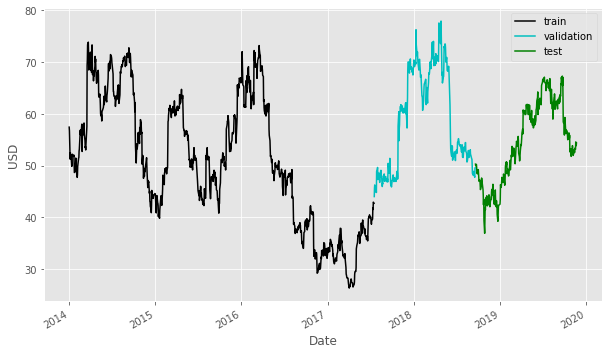

In [4]:
fig,ax=plt.subplots(figsize=(10,6))
for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax = d.plot(x='date', y='adj_close', style=s, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("USD")
plt.show();

### Training

In [5]:
metrics = pd.DataFrame()
y_pred = data[ntrain-1:ntrval-1].adj_close.values

m = forecast_metrics(val.adj_close, y_pred, 'Persistence')
metrics = metrics.append(m)

print(metrics)

                 RMSE     MAPE     SMAPE    MinMax     Corr
Persistence  1.605851  1.80438  1.807754  1.773259  0.98601


### Plotting on Valication set

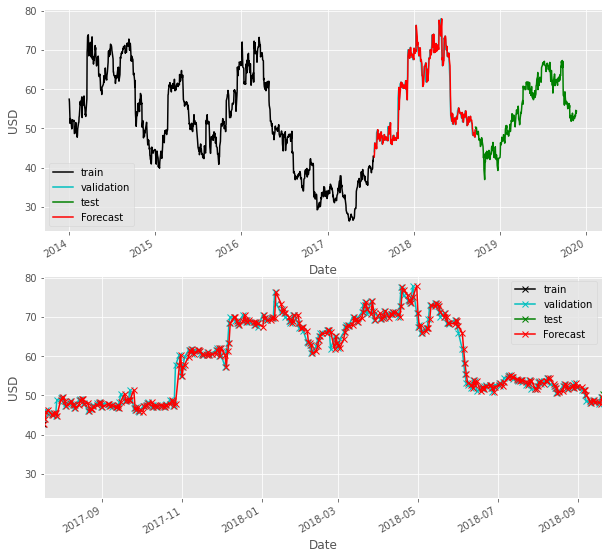

In [6]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(val.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(val.date, y_pred, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([val.date.min(), val.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

### Final model, Testing

In [7]:
metrics = pd.DataFrame()
y_pred = data[ntrval-1:ndata-1].adj_close.values

m = forecast_metrics(test.adj_close, y_pred, 'Persistence')
metrics = metrics.append(m)

print(metrics)

                 RMSE      MAPE     SMAPE    MinMax      Corr
Persistence  1.257067  1.746816  1.744315  1.716753  0.986942


### Plotting on test set

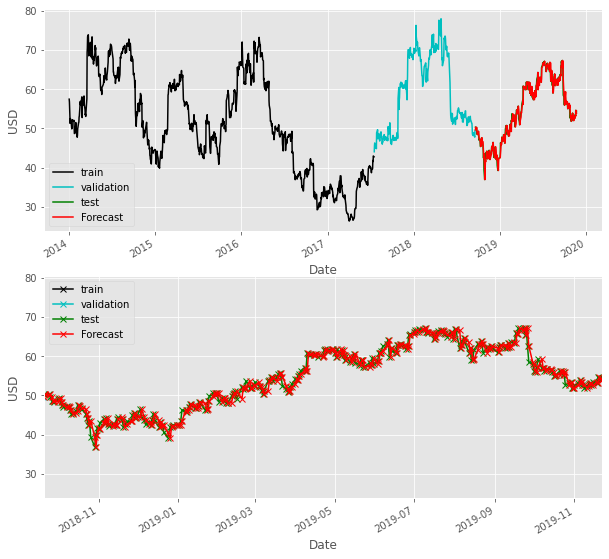

In [8]:
fig,ax=plt.subplots(2,1,figsize=(10,10))

for d,s in zip([train, val, test], ['k-', 'c-', 'g-']):
    ax[0] = d.plot(x='date', y='adj_close', style=s, ax=ax[0])
ax[0].plot(test.date, y_pred, 'r-')
ax[0].legend(['train', 'validation', 'test', 'Forecast'])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("USD")

for d,s in zip([train, val, test], ['kx-', 'cx-', 'gx-']):
    ax[1] = d.plot(x='date', y='adj_close', style=s, ax=ax[1])
ax[1].plot(test.date, y_pred, 'rx-')
ax[1].legend(['train', 'validation', 'test', 'Forecast'])
ax[1].set_xlim([test.date.min(), test.date.max()])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("USD")
#ax[1].text(0.5, 0.5, "Zoomed In")

plt.show();

### Save predictions

In [9]:
test['forcast'] = y_pred
test.to_csv("./out/test_persisence.csv")

In [10]:
print(metrics)

                 RMSE      MAPE     SMAPE    MinMax      Corr
Persistence  1.257067  1.746816  1.744315  1.716753  0.986942
